# Instructions

Now that you've learned about random forests and decision trees let's do an exercise in accuracy. You know that random forests are basically a collection of decision trees. But how do the accuracies of the two models compare?

So here's what you should do. Pick a dataset. It could be one you've worked with before or it could be a new one. Then build the best decision tree you can.

Now try to match that with the simplest random forest you can. For our purposes measure simplicity with runtime. Compare that to the runtime of the decision tree. This is imperfect but just go with it.

Hopefully out of this you'll see the power of random forests, but also their potential costs. Remember, in the real world you won't necessarily be dealing with thousands of rows. It could be millions, billions, or even more.

# Load and clean

Note: this is the housing prace dataset that I've worked with once before.  The target variable (house price) is numeric rather than categorical, so I'll be using a decision tree and then a random forest to run regression on it.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [7]:
housing_df = pd.read_csv("khous_train.csv")
housing_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


First, let's drop categorical columns that either totally uniform or too heavily skewed to be of much use.

In [8]:
# Note: I used the code below to print out the value counts for the columns 
# and see which ones were too skewed to be very useful
# for column in housing_df:
#     dtype = housing_df[column].dtype
#     valcounts = housing_df[column].value_counts()
#     if dtype == object: 
#         print(column)
#         print(housing_df[column].value_counts())
#         print("********************************")

# based on those results, we can drop some nearly one-value-only columns:
drop_feats = ["Street","Alley","Utilities","Condition2","RoofMatl","Heating","PoolQC","MiscFeature"]
housing_df.drop(drop_feats, axis=1, inplace=True)

# and we might later consider dropping Neighborhood, since it will generate almost 20 dummy columns

Then we'll drop columns that have more than 100 NaNs:

In [9]:
count = 0
for column in housing_df:
    if housing_df[column].isnull().sum() > 100:
        housing_df.drop(column, axis=1, inplace=True)
        count += 1
print(count)

3


In [5]:
len(housing_df) - len(housing_df.dropna())

122

We lost three columns because they had more than 100 NaNs.  We'll lose 122 rows when we drop all remaining NaNs; we can probably afford this.  The NaNs are mostly in the garage area; they may represent houses without garages.  If that's the case, thsi might hurt our predictions on houses that don't have garages.  If I were really trying to optimize performance here, I'd take a closer look at that and check accuracy with dropping the rows vs. dropping the columns.  For now, though, we'll just drop the rows.

In [10]:
housing_df.dropna(inplace=True)

# Running the decision tree

First, we'll set up our datasets for input:

In [12]:
from sklearn.model_selection import train_test_split

all_X = pd.get_dummies(housing_df.drop("SalePrice", axis=1))
all_Y = housing_df['SalePrice']

train, test = train_test_split(housing_df, test_size=0.25)
X_train = pd.get_dummies(train.drop("SalePrice", axis=1))
y_train = train["SalePrice"]
X_test = pd.get_dummies(test.drop("SalePrice", axis=1))
y_test = test['SalePrice']

Then let's try running our tree for various tree depths with max_features set to 10.

[0.24796857118211957, 0.31475056791453326, 0.42787893416853573, 0.5108155395337118, 0.5870438625840761, 0.5524398946155811, 0.5724432176163362, 0.34269793635467694, 0.5118288042331827, 0.5336547458543197, 0.4489952493196156, 0.5720206540252406, 0.5805558307843675, 0.5061779772610141]


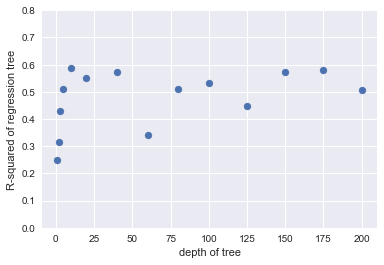

In [17]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

tree_depths = [1,2,3,5,10,20,40,60,80,100,125,150,175,200]
scores = []
for tree_depth in tree_depths:
    decision_tree = tree.DecisionTreeRegressor(
        max_features=10,
        max_depth=tree_depth)
    scores.append(np.mean(cross_val_score(decision_tree, all_X, all_Y, cv=8)))
print(scores)

plt.scatter(tree_depths, scores)
plt.xlabel("depth of tree")
plt.ylabel("R-squared of regression tree")
plt.ylim((0,0.8))
plt.show()

As we can see above, if we run the tree with only 10 features (max_features) checked at each split, we max out our accuracy around R-squared = 0.6.  Deeper trees cease to improve our model beyond about 10 levels of tree depth, but show no signs of overfitting with further levels.  Let's try searching all available features at each split:

[0.44884889466169586, 0.5702398293111944, 0.661098127433653, 0.7310808348726826, 0.7333164197995279, 0.6706175221583398, 0.6733277434528051, 0.6982400032921667, 0.6636132331361067, 0.6733146051732679, 0.6746400028389974, 0.6838625587168286, 0.6744688894475512, 0.6733728521541087]


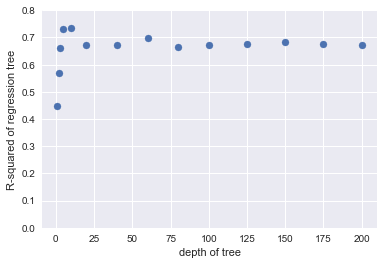

--- 4.098346948623657 seconds ---


In [19]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
import time

start_time = time.time()

tree_depths = [1,2,3,5,10,20,40,60,80,100,125,150,175,200]
scores = []
for tree_depth in tree_depths:
    decision_tree = tree.DecisionTreeRegressor(
        max_features='auto',
        max_depth=tree_depth)
    scores.append(np.mean(cross_val_score(decision_tree, all_X, all_Y, cv=8)))
print(scores)

plt.scatter(tree_depths, scores)
plt.xlabel("depth of tree")
plt.ylabel("R-squared of regression tree")
plt.ylim((0,0.8))
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

In this case we again max out the usefulness of our tree depth very quickly, around 10 levels.  Our accuracy peaks at about R-squared = 0.7.  On the upside, even considering all the features and running over all the max_depths input above, this only takes about 4 seconds to run.

# Running the random forest

Now let's try running a random forest on this dataset instead:

In [20]:
from sklearn import ensemble

start_time = time.time()

rfc = ensemble.RandomForestRegressor()
cv_scores = cross_val_score(rfc, all_X, all_Y, cv=8)

print(cv_scores)
print("mean score: " + str(np.mean(cv_scores)) + "\n")
print("--- %s seconds ---" % (time.time() - start_time))

[0.80359326 0.8347399  0.84382925 0.86428521 0.87925601 0.8608384
 0.84524809 0.6368617 ]
mean score: 0.8210814769685792

--- 2.03299617767334 seconds ---


Interesting: the accuracy improves, AND it runs very fast.  Reasons for the speed:
- I'm only doing this once, whereas I ran the random tree a dozen times - so the random forest is still several times slower
- the dataset is small
- the sklearn package is well optimized

Now let's see if we can make this model more accurate with a bit of feature elimination (which will help only if we're overfitting), selecting only the *n* most important features:

In [21]:
rfc.fit(all_X, all_Y)
importances = rfc.feature_importances_
labeled_importances = []
for i in range(len(all_X.columns)):
    labeled_importances.append( (importances[i], all_X.columns[i]) )
labeled_importances.sort(reverse=True)
top_10 = [tup[1] for tup in labeled_importances[:10]]
top_20 = [tup[1] for tup in labeled_importances[:20]]
top_30 = [tup[1] for tup in labeled_importances[:30]]
top_50 = [tup[1] for tup in labeled_importances[:50]]
labeled_importances

[(0.5694714577283732, 'OverallQual'),
 (0.08351445188381675, 'GrLivArea'),
 (0.05928354534662143, '2ndFlrSF'),
 (0.04462966934235636, 'FullBath'),
 (0.023525970017313307, 'BsmtFinSF1'),
 (0.02148000757446814, 'TotalBsmtSF'),
 (0.01910648038977833, '1stFlrSF'),
 (0.017857515555026147, 'LotArea'),
 (0.010816182505493134, 'TotRmsAbvGrd'),
 (0.010397719025679234, 'GarageCars'),
 (0.00925236243458494, 'GarageArea'),
 (0.00895196510295616, 'YearBuilt'),
 (0.007497194303035469, 'YearRemodAdd'),
 (0.006436971033613001, 'OverallCond'),
 (0.005981886261529915, 'MoSold'),
 (0.005884104510034223, 'BsmtUnfSF'),
 (0.005829754805456345, 'WoodDeckSF'),
 (0.005770573533423864, 'BsmtQual_Ex'),
 (0.005738066478794714, 'Fireplaces'),
 (0.0050051846952703805, 'MasVnrArea'),
 (0.004768201517968445, 'OpenPorchSF'),
 (0.004467468729282305, 'GarageType_Detchd'),
 (0.004371852905231334, 'Id'),
 (0.004317532289349439, 'GarageYrBlt'),
 (0.004106315764739251, 'PoolArea'),
 (0.0032501929438319608, 'MSZoning_RM'),
 

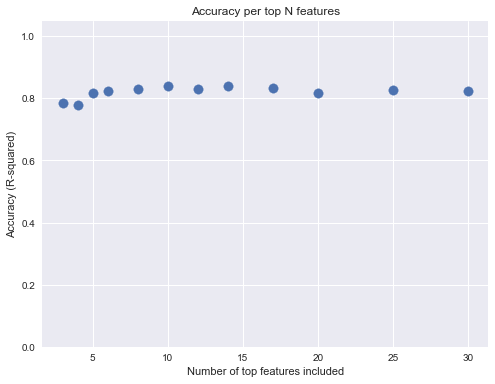

In [25]:
top_n_features = [3,4,5,6,8,10,12,14,17,20,25,30]
accuracies = []
# this loop calculates 
for n in top_n_features:
    cols = [tup[1] for tup in labeled_importances[:n]]
    X_temp = all_X[cols]
    rfc_temp = ensemble.RandomForestRegressor()
    acc = np.mean(cross_val_score(rfc_temp, X_temp, all_Y, cv=3))
    accuracies.append(round(acc, 3))
plt.figure(figsize=(8,6))
plt.scatter(top_n_features, accuracies, s=90)
plt.title("Accuracy per top N features")
plt.xlabel("Number of top features included")
plt.ylabel("Accuracy (R-squared)")
plt.ylim((0,1.05))
plt.show()

Interesting: it looks like we hit our peak accuracy by about the top 10 features; from then on, we don't really get better or worse.  And indeed, if we run our scores for just the top 10 features:

In [26]:
start_time = time.time()

rfc = ensemble.RandomForestRegressor()
cv_scores = cross_val_score(rfc, all_X[top_10], all_Y, cv=8)

print(cv_scores)
print("mean score: " + str(np.mean(cv_scores)) + "\n")
print("--- %s seconds ---" % (time.time() - start_time))

[0.83508167 0.85391615 0.74844684 0.86728324 0.86254284 0.86591873
 0.87447456 0.80890456]
mean score: 0.8395710739326472

--- 0.4075620174407959 seconds ---


We get essentially the same score as we get using all the features, but in less than a third of the time.  So as in the last project, it seems that the accuracy gains after a fairly small number of most-important-features are very marginal, and the time gains from cutting the extra features are significant.

MY QUESTION: I can understand why the random forest wouldn't overfit because of the many random trees that will wash out the noise.  But why doesn't the tree overfit?
